# Aprendizaje no supervisado

Los algoritmos que hemos visto pertenecen a un paradigma denominado "aprendizaje supervisado" y hace referencia al hecho de que es necesaria una base de datos **etiquetada por un experto** para que el algoritmo aprenda. En otras palabras, el algoritmo necesita la **supervisión** de un experto. 

Por otro lado, el "aprendizaje no supervisado" se refiere al paradigma de aprendizaje que no usa etiquetas de clase (por lo tanto estos algoritmos no pueden ser llamados clasificadores) sino que se basa en la similitud entre las muestras para tratar de encontrar los "agrupamientos naturales" que existan en la base de datos. Este paradigma también es llamado *clustering* y puede considerarse una estrategia descriptiva en lugar de predictiva, ya que se interesa en descubrir la estructura de los datos en lugar de aprender a diferenciarlos mediante un entrenamiento.

¿Cuántos agrupamientos "naturales" se podrían hacer en la siguiente imagen?

<img src="../doc/images/simpson.jpg" width=450/>

Por supuesto, los agrupamientos que hagamos están directamente relacionados con las características que extraigamos de los objetos. Pero aún teniendo unas características específicas, puede ser difícil definir cuáles agrupamientos describen los datos.

¿Cuántos *clusters* hay en los siguientes datos?

<img src="../doc/images/data_clusters.png" width=350/>

No hay una sola forma de ver el problema:

<img src="../doc/images/data_clusters2.png" width=800/>

Si esto fuera un problema de aprendizaje supervisado, podría provenir de varios escenarios:

<img src="../doc/images/data_clusters3.png" width=800/>


## Métodos jerárquicos

Los métodos jerárquicos son tal vez el los métodos más comúnmente usados para resumir la estructura de un conjunto de datos. Un árbol jerárquico es un conjunto anidado de particiones, representadas en un diagrama conocido como *dendrograma*.

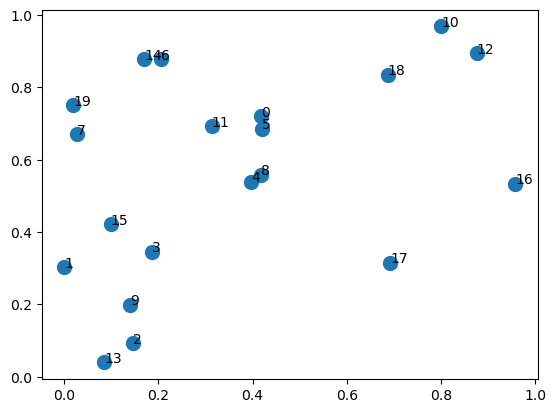

In [1]:
#Vamos a crear 20 muestras aleatorias de dos dimensiones
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)
X = np.random.rand(20, 2) # 20 muestras de dos dimensiones cada una
plt.scatter(X[:, 0], X[:, 1],s=100)
for i in range(len(X)):
    plt.annotate(i,X[i])

plt.show()

In [2]:
#Veamos el dendrograma que producen
import scipy
import numpy as np
if not hasattr(scipy, "array"):
    scipy.array = np.array

import plotly.figure_factory as ff
dend = ff.create_dendrogram(X)
dend.show(renderer="notebook_connected")

In [8]:
y=np.zeros(len(X))
y[[18,10,12,16,17]]=1;
y[[9,2,13,1,3,15]]=2;
print(y)

[0. 2. 2. 2. 0. 0. 0. 0. 0. 2. 1. 0. 1. 2. 0. 2. 1. 1. 1. 0.]


In [9]:
import pandas as pd
media_total=np.asmatrix(np.mean(X,axis=0)); #Media total
clases=pd.DataFrame(X).groupby(y)
medias=np.array(clases.mean()); #Matriz con las medias de cada clase
covarianzas=clases.cov();
ni=clases.size(); #Número de muestras de cada clase
SB=0
SW=0
for j in range(len(medias)):
    SB=SB+ni[j]/len(y)*(np.transpose(medias[j,:]-media_total).dot(medias[j,:]-media_total))
    Sigmai=covarianzas.loc[j]
    SW=SW+ni[j]/len(y)*(Sigmai)
J4=sum(np.diag(SB))/sum(np.diag(SW))
print(J4)

2.4312771520580876


El agrupamiento de los datos se convierte entonces en un problema de escala una vez se tiene el correspondiente dendrograma. Seccionar el árbol a diferentes niveles, producirá diferentes clusters. Sin embargo, la forma de construir un dendrograma tampoco es única y se pueden usar diferentes criterios para construir las uniones, conocidos como **criterios de enlace**.

**Enlace sencillo**: La distancia entre dos grupos de muestras es igual a la **mínima** distancia entre las muestras de cada grupo.

**Enlace completo**: La distancia entre dos grupos de muestras es igual a la **máxima** distancia entre las muestras de cada grupo.

**Enlace promedio**: La distancia entre dos grupos de muestras es igual a la distancia entre los centroides de cada grupo.

<img src="../doc/images/linkages.png" width=800/>


In [3]:
#Veamos los diferentes dendrogramas que podemos construir con los mismos datos
import plotly.figure_factory as ff
import scipy.cluster.hierarchy as sch
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=3)
dend_single = ff.create_dendrogram(X,linkagefun=lambda x: sch.linkage(x, "single"))
dend_complete = ff.create_dendrogram(X,linkagefun=lambda x: sch.linkage(x, "complete"))
dend_average = ff.create_dendrogram(X,linkagefun=lambda x: sch.linkage(x, "average"))
dend_single.update_layout(width=600, height=400)
dend_single.show(renderer="notebook_connected")
dend_complete.update_layout(width=600, height=400)
dend_complete.show(renderer="notebook_connected")
dend_average.update_layout(width=600, height=400)
dend_average.show(renderer="notebook_connected")

## Métodos basados en centroides: Algoritmo k-medias

El algoritmo k-medias está basado en la mimnimización de la distancia intra-grupo para cada una de las agrupaciones. En su forma más simple, el algoritmo consta de tres pasos:

1. **Inicialización**: una vez escogido el número de grupos, k, se establecen k centroides en el espacio de los datos, por ejemplo, escogiéndolos aleatoriamente.
2. **Asignación objetos a los centroides**: cada objeto de los datos es asignado a su centroide más cercano.
3. **Actualización centroides**: se actualiza la posición del centroide de cada grupo tomando como nuevo centroide la posición del promedio de los objetos pertenecientes a dicho grupo.

<img src="kmeans.png" width=600/>

1000
[1 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0]


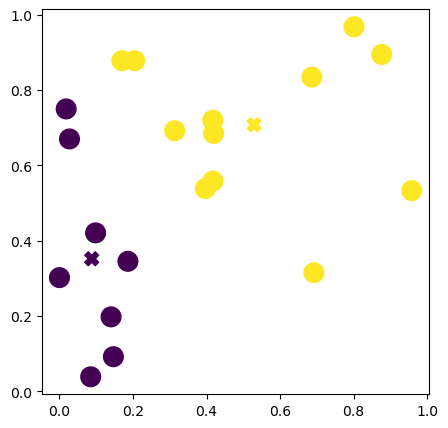

In [20]:
#Primero vamos a definir una función que calcule todas las distancias entre las filas de dos matrices
#Basada en la función dist2 de matlab hecha por Ian T. Nabney
def dist_matr(X,Y):
    nx=len(X)
    ny=len(Y)
    X2=np.repeat(np.sum(X**2,axis=1),ny)
    X2=np.reshape(X2,(-1,ny)) #Matriz con los elementos de X^2, de tamaño nx X ny
    Y2=np.repeat(np.sum(Y**2,axis=1),nx)
    Y2=np.reshape(Y2,(nx,-1),'F') #Matriz con los elementos de Y^2, de tamaño nx X ny
    XY = X.dot(np.transpose(Y)) #Matriz con los elementos de XY, de tamaño nx X ny
    dist=X2+Y2-2*XY;
    dist[np.where(dist<0)]=0; #Para evitar errores por redondeo
    dist=np.sqrt(dist)
    return dist

#Inicialización aleatoria de los centroides
k=2 #Número de centroides
pcent=np.random.choice(20,k)
centroides=X[pcent,:]

cond=0;
itera=0;
max_iter=1000;
while(cond==0):
    itera=itera+1;
    D=dist_matr(centroides,X) #Se calculan las distancias de todas las muestras a los centroides
    clusters=np.argmin(D,axis=0)
    centroides_nuevos=np.zeros(np.shape(centroides))
    for i in range(k):
        centroides_nuevos[i,:]=np.mean(X[np.where(clusters==i)],axis=0)
    if np.all(centroides==centroides_nuevos) | itera>=max_iter:
        cond=1
    else: 
        centroides=centroides_nuevos

print(itera)
plt.rcParams["figure.figsize"]=5,5 #Modifica el tamaño de la gráfica
plt.scatter(X[:, 0], X[:, 1],c=clusters,s=200)
plt.scatter(centroides[:, 0], centroides[:, 1],c=range(k),s=100,marker='X')
print(clusters)

In [21]:
import pandas as pd
media_total=np.asmatrix(np.mean(X,axis=0)); #Media total
clases=pd.DataFrame(X).groupby(clusters)
medias=np.array(clases.mean()); #Matriz con las medias de cada clase
covarianzas=clases.cov();
ni=clases.size(); #Número de muestras de cada clase
SB=0
SW=0
for j in range(len(medias)):
    SB=SB+ni[j]/len(y)*(np.transpose(medias[j,:]-media_total).dot(medias[j,:]-media_total))
    Sigmai=covarianzas.loc[j]
    SW=SW+ni[j]/len(y)*(Sigmai)
J4=sum(np.diag(SB))/sum(np.diag(SW))
print(J4)

0.8369964745658535


## Métodos basados en grafos: Clustering espectral
 
El clustering espectral hace uso del espectro (valores propios) de la matriz de similitud de los datos para hacer una reducción de dimensiones y agrupar los datos en este espacio reducido. Para realizar el clustering espectral, definimos:

**Matriz de similitud (o adyacencia) A**: Es una matriz simétrica cuyo elemento $A_{ij}$ es la similitud entre el i-ésimo y el j-ésimo objeto de la base de datos.

**Matriz de grado D**: Es una matriz diagonal cuyos elementos cumplen
\begin{equation}
D_{ii} = \sum_{j} A_{ij}
\end{equation}

**Matriz Laplaciana**: Es una matriz cutos valores propios son siempre reales positivos (definida positiva) y sus vectores propios son ortogonales.
\begin{equation}
L = D-A
\end{equation}

**Matriz Laplaciana Normalizada**:
\begin{equation}
L_{rw}=D^{-1}L
\end{equation}

Una vez calculados los vectores propios de $L_rw$, se procede a realizar un clustering sobre la matriz con los primeros $n$ vectores propios, típicamente con k-medias.


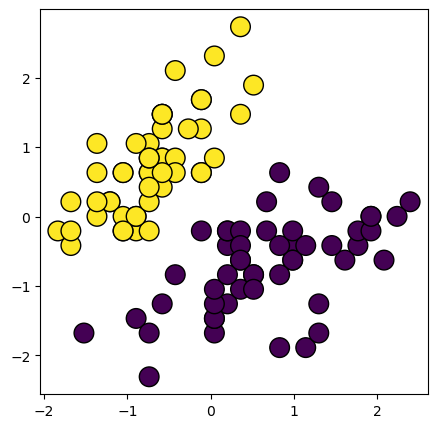

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

iris = datasets.load_iris()
X = iris.data[0:100, :2]
X = (X - X.mean(axis=0)) / X.std(axis=0)

dist=dist_matr(X,X) #Distancias
A = np.exp(-dist**2) #Similitudes

# Laplaciano no normalizado
D = np.diag(A.sum(axis=1))
L = D - A
Lrw = np.dot(np.linalg.inv(D),L)


# Espectral: k autovectores de menor autovalor
k = 2
w, V = np.linalg.eigh(L)
U = V[:, np.argsort(w)[:k]]

# k-means en el embedding
clases = KMeans(n_clusters=k, n_init=20, random_state=0).fit_predict(U)

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=clases, s=200, edgecolor='k')
plt.show()

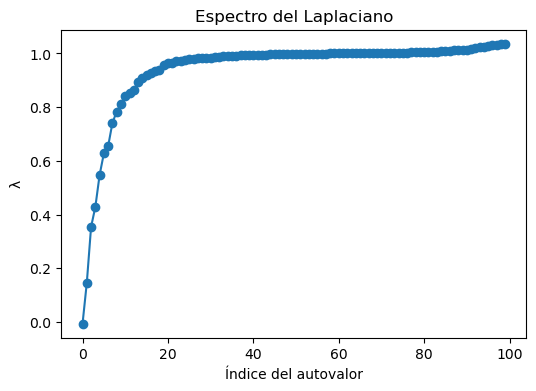

Número óptimo de clusters ≈ 2


In [23]:
import numpy as np
import matplotlib.pyplot as plt

w, V = np.linalg.eigh(Lrw)
w = np.real(w)
w.sort()

#Gráfica del espectro
plt.figure(figsize=(6,4))
plt.plot(w, 'o-')
plt.title('Espectro del Laplaciano')
plt.xlabel('Índice del autovalor')
plt.ylabel('λ')
plt.show()

# Brecha espectral
diffs = np.diff(w)
k_opt = np.argmax(diffs) + 1  #Brecha más grande
print("Número óptimo de clusters ≈", k_opt)